In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, dopioe


In [2]:
def unit_det(Q, symmetrize=True):
    Q = np.asarray(Q, dtype=float)
    d = np.linalg.det(Q)
    if not np.isfinite(d) or d <= 0: raise ValueError("det(Q) must be positive and finite")
    s = 1/np.sqrt(d)
    return s*Q, s

def tangential_velocity(xp, yp, up, vp, xc, yc, Q, det1=False):
    Q = np.asarray(Q, float)
    if Q.shape == (3,):
        q11, q12, q22 = Q
        Q = np.array([[q11, q12], [q12, q22]], float)
    if det1:
        d = np.linalg.det(Q)
        if d != 0:
            Q /= np.sqrt(d)

    xp, yp, up, vp = (np.asarray(a, float) for a in (xp, yp, up, vp))
    r   = np.stack((xp - xc, yp - yc), axis=-1)
    g   = 2.0 * (r @ Q.T)                    # ∇F
    J   = np.array([[0., -1.], [1., 0.]])    # +90° rot
    tau = g @ J.T                             # tangent
    nrm = np.linalg.norm(tau, axis=-1, keepdims=True)
    t_hat = np.divide(tau, nrm, out=np.zeros_like(tau), where=nrm > 0)

    vel = np.stack((up, vp), axis=-1)
    vt  = np.sum(vel * t_hat, axis=-1)
    vt  = np.where(nrm.squeeze() > 0, vt, np.nan)
    return vt#, t_hat
    

In [3]:
x, y = np.linspace(-100, 100, 100), np.linspace(-100, 100, 100)
X, Y = np.meshgrid(x, y, indexing='ij')

xc, yc = 0, 0
Q11, Q12, Q22 = 1, 0.25, 1
psi0 = -100
Rc = 35
A = - psi0 / Rc**2

# rescale Q to have unit determinant
Q, _ = unit_det(Q=np.array([[Q11, Q12], [Q12, Q22]]))
q11, q12, q22 = Q[0,0], Q[0,1], Q[1,1]

df_res = pd.DataFrame({'xc': [xc], 'yc': [yc], 'q11': [q11], 'q12': [q12], 'q22': [q22],
                       'Rc': [Rc], 'psi0': [psi0], 'A': [A]})

dx, dy = X - xc, Y - yc
# rho2 = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
rho2 = (q11*dx + q12*dy)**2 + (q12*dx + q22*dy)**2 # ||Qr||
psi = psi0 * np.exp( - rho2 / Rc**2 )
u =   psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q12*dx + 2*q22*dy ) / Rc**2
v = - psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q11*dx + 2*q12*dy ) / Rc**2

vt = -2*A*np.sqrt(rho2)*np.exp(-rho2/Rc**2)

df_res


,xc,yc,q11,q12,q22,psi0,Rc,A
0,0,0,1.032796,0.258199,1.032796,-100,35,0.081633


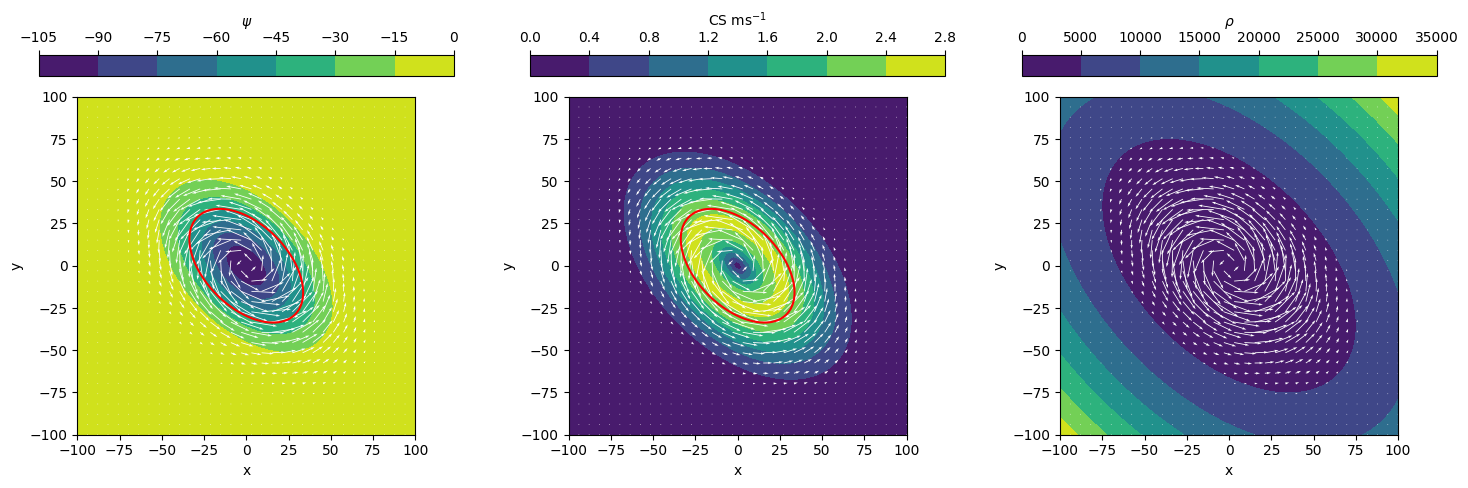

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# First subplot
c0 = axs[0].contourf(X, Y, psi)
fig.colorbar(c0, ax=axs[0], label=r'$\psi$',
             orientation='horizontal', location='top')
spac = 3
axs[0].quiver(X[::spac, ::spac], Y[::spac, ::spac],
              u[::spac, ::spac], v[::spac, ::spac], color='white')
axs[0].contour(X, Y, rho2, colors='r', levels=[1000], alpha=1)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')

# Second subplot
c1 = axs[1].contourf(X, Y, np.hypot(u, v))
fig.colorbar(c1, ax=axs[1], label=r'CS ms$^{-1}$',
             orientation='horizontal', location='top')
axs[1].quiver(X[::spac, ::spac], Y[::spac, ::spac],
              u[::spac, ::spac], v[::spac, ::spac], color='white')
axs[1].contour(X, Y, rho2, colors='r', levels=[1000], alpha=1)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_aspect('equal')

c2 = axs[2].contourf(X, Y, rho2)
fig.colorbar(c2, ax=axs[2], label=r'$\rho$',
             orientation='horizontal', location='top')
axs[2].quiver(X[::spac, ::spac], Y[::spac, ::spac],
              u[::spac, ::spac], v[::spac, ::spac], color='white')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_aspect('equal')

plt.tight_layout()
plt.show()


In [5]:
x0, y0 = 0, 0
r = 25
# nearest indices to (x0, y0)
i0 = np.argmin(np.abs(x - x0))
j0 = np.argmin(np.abs(y - y0)) 
# zonal transect at y = y0
mask_x = np.abs(x - x0) < r
x1, y1 = x[mask_x], np.full(np.sum(mask_x), y[j0])
u1, v1 = u[mask_x, j0], v[mask_x, j0]
# meridional transect at x = x0
mask_y = np.abs(y - y0) < r
x2, y2 = np.full(np.sum(mask_y), x[i0]), y[mask_y]
u2, v2 = u[i0, mask_y], v[i0, mask_y]

points1 = set(zip(x1, y1)); points2 = set(zip(x2, y2))
common_points = points1 & points2
# Remove duplicates from (x1, y1, u1, v1)
mask = ~np.array([(x, y) in common_points for x, y in zip(x1, y1)])
x1f = x1[mask]; y1f = y1[mask]; u1f = u1[mask]; v1f = v1[mask]
# Concatenate with unaltered second set
xi = np.concatenate([x1f, x2]); yi = np.concatenate([y1f, y2])
ui = np.concatenate([u1f, u2]); vi = np.concatenate([v1f, v2])

xc_dop, yc_dop, w_dop, AQ_dop, *_ = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
A_dop = np.sqrt(np.linalg.det(AQ_dop)) # det(Q) = 1, A = -psi0/Rc**2
q11_dop, q12_dop, q22_dop = AQ_dop[0,0]/A_dop, AQ_dop[1,0]/A_dop, AQ_dop[1,1]/A_dop
Q_dop = np.array([[q11_dop, q12_dop], [q12_dop, q22_dop]])

dx_dop, dy_dop = xi - xc_dop, yi - yc_dop
rho2_dop = q11_dop*dx_dop**2 + 2*q12_dop*dx_dop*dy_dop + q22_dop*dy_dop**2
# rho_dop = np.sqrt(rho2_dop)
rho_dop = np.sqrt((q11_dop*dx_dop + q12_dop*dy_dop)**2
                  + (q12_dop*dx_dop + q22_dop*dy_dop)**2) #||Qr||
vt_dop = np.abs(tangential_velocity(xi, yi, ui, vi, xc_dop, yc_dop, Q_dop))
idx_max_vt = np.where(vt_dop==np.max(vt_dop))[0][0]
rho_dop_max = rho_dop[idx_max_vt]
Rc_dop = rho_dop_max * np.sqrt(2) # Rc = rho_max * np.sqrt(2)
psi0_dop = - A_dop * Rc_dop**2 

df_res.loc[len(df_res)] = {'xc': xc_dop, 'yc': yc_dop, 'q11': q11_dop, 'q12': q12_dop, 'q22': q22_dop,
                           'Rc': Rc_dop, 'psi0': psi0_dop, 'A': A_dop}
df_res


,xc,yc,q11,q12,q22,psi0,Rc,A
0,0.000000,0.000000,1.032796,0.258199,1.032796,-100.000000,35.000000,0.081633
1,-0.010563,-0.010563,1.032661,0.257661,1.032661,-93.349816,34.303594,0.079329


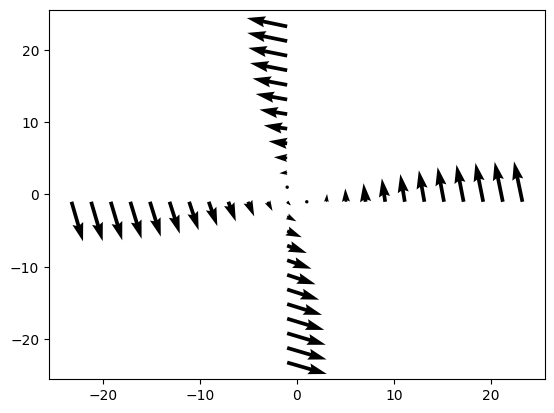

In [6]:
plt.quiver(x1, y1, u1, v1)
plt.quiver(x2, y2, u2, v2)


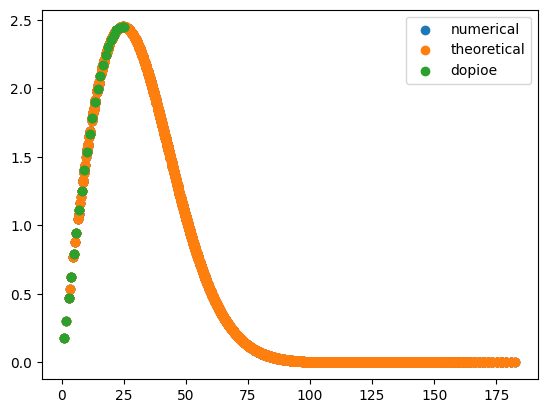

In [7]:
points1 = set(zip(x1, y1)); points2 = set(zip(x2, y2))
common_points = points1 & points2
# Remove duplicates from (x1, y1, u1, v1)
mask = ~np.array([(x, y) in common_points for x, y in zip(x1, y1)])
x1f = x1[mask]; y1f = y1[mask]; u1f = u1[mask]; v1f = v1[mask]
# Concatenate with unaltered second set
xi = np.concatenate([x1f, x2]); yi = np.concatenate([y1f, y2])
ui = np.concatenate([u1f, u2]); vi = np.concatenate([v1f, v2])

vt_numerical = tangential_velocity(X.flatten(), Y.flatten(), u.flatten(), v.flatten(), xc, yc, Q)
plt.scatter(np.sqrt(rho2), np.abs(vt_numerical), label='numerical') # Why does this not match the theoretical????

plt.scatter(np.sqrt(rho2), np.abs(vt), label='theoretical')

plt.scatter(rho_dop, np.abs(vt_dop), label='dopioe')

plt.legend()


### ROMS data

In [8]:
import pickle
df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_eddies_processed_1462_10650.pkl')


In [9]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')
fnumber_old = 0


In [65]:
df_eddies[df_eddies.Eddy==971]


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,Q11,Q12,Q22,Rc,psi0,Age,Date,fname
39029,971,4490,AE,154.275086,-38.001410,196,54,577.313153,265.207898,0.000040,0.009539,-0.000137,0.010365,53.000705,-999999.975654,230,2002-04-18,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
39030,971,4491,AE,154.246004,-38.047089,195,53,576.291854,259.520920,0.000039,0.009847,-0.000194,0.009869,54.250823,-750027.825595,230,2002-04-19,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
39031,971,4492,AE,154.216922,-38.092768,195,51,575.270554,253.833941,0.000039,0.010155,-0.000251,0.009373,55.500940,-500055.675536,230,2002-04-20,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
39032,971,4493,AE,154.187840,-38.138447,195,50,574.249255,248.146963,0.000039,0.010463,-0.000308,0.008877,56.751057,-250083.525477,230,2002-04-21,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
39033,971,4494,AE,154.158758,-38.184127,195,49,573.227956,242.459985,0.000038,0.010772,-0.000366,0.008381,58.001174,-111.375418,230,2002-04-22,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39254,971,4715,AE,155.919801,-37.764749,223,69,709.022633,340.071629,0.000012,0.002836,0.001169,0.003365,43.000035,-5.612798,230,2002-11-29,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
39255,971,4716,AE,155.943200,-37.853988,224,67,713.651088,331.336662,0.000012,0.002796,0.001397,0.003210,41.751543,-5.128582,230,2002-11-30,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
39256,971,4717,AE,155.885468,-37.894440,223,66,709.959824,325.298187,0.000010,0.001863,0.000025,0.002905,39.500620,-6.284177,230,2002-12-01,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
39257,971,4718,AE,155.805171,-37.664667,220,70,696.319380,347.170273,0.000011,0.001663,0.000279,0.003938,24.006235,-6.072463,230,2002-12-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [66]:
eddy = 971
day = 4550

r = 150
data = df_eddies[(df_eddies.Eddy==eddy)&(df_eddies['Day']==day)].iloc[0]
fname = data.fname
fnumber = fname[-8:-3]
if fnumber != fnumber_old:

    u_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/u_' + fnumber + '.npy')
    v_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/v_' + fnumber + '.npy')
    
    u_raw = np.where(np.abs(u_raw) > 1e30, np.nan, u_raw).astype(float)
    v_raw = np.where(np.abs(v_raw) > 1e30, np.nan, v_raw).astype(float)
    
    with nc.Dataset(fname) as dataset:
        ocean_time = dataset.variables['ocean_time'][:].data / 86400
    fnumber_old = fnumber
t_rel = np.where(ocean_time == day)[0][0]

u_t, v_t = u_raw[:, :, :, t_rel], v_raw[:, :, :, t_rel]

xc_surf, yc_surf = data.xc, data.yc
ic = np.where(np.abs(x_grid-xc_surf)==np.min(np.abs(x_grid-xc_surf)))[0][0]
jc = np.where(np.abs(y_grid-yc_surf)==np.min(np.abs(y_grid-yc_surf)))[0][0]

x_mask = np.where(np.abs(x_grid - xc_surf) < r)[0]
y_mask = np.where(np.abs(y_grid - yc_surf) < r)[0]
X_mask, Y_mask = np.meshgrid(x_mask, y_mask)


(np.float64(514.4696516522415),
 np.float64(809.4955947138037),
 np.float64(133.0742746412878),
 np.float64(429.0525207980879))

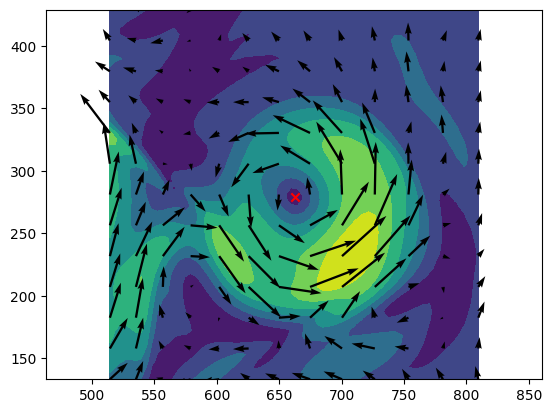

In [67]:
k = 0
plt.contourf(X_grid[X_mask, Y_mask], Y_grid[X_mask, Y_mask], np.hypot(u_t[X_mask, Y_mask,k], v_t[X_mask, Y_mask,k]))
spac = 5
plt.quiver(X_grid[X_mask[::spac, ::spac], Y_mask[::spac, ::spac]], Y_grid[X_mask[::spac, ::spac], Y_mask[::spac, ::spac]],
           u_t[X_mask[::spac, ::spac], Y_mask[::spac, ::spac],k], v_t[X_mask[::spac, ::spac], Y_mask[::spac, ::spac],k])
plt.scatter(data.xc, data.yc, marker='x', color='r')
plt.axis('equal')


In [68]:
X_local, Y_local = X_grid[X_mask, Y_mask], Y_grid[X_mask, Y_mask]
x_local, y_local = X_local[0,:], Y_local[:,0]
u_local, v_local = u_t[X_mask, Y_mask,k].T, v_t[X_mask, Y_mask,k].T


In [80]:
x0, y0 = xc_surf, yc_surf
r = 40

i0 = np.argmin(np.abs(x_local - x0))
j0 = np.argmin(np.abs(y_local - y0))

mask_x = np.abs(x_local - x0) < r
x1 = x_local[mask_x]
y1 = np.full(mask_x.sum(), y_local[j0])
u1 = u_local[mask_x, j0]
v1 = v_local[mask_x, j0]

mask_y = np.abs(y_local - y0) < r
x2 = np.full(mask_y.sum(), x_local[i0])
y2 = y_local[mask_y]
u2 = u_local[i0, mask_y]
v2 = v_local[i0, mask_y]


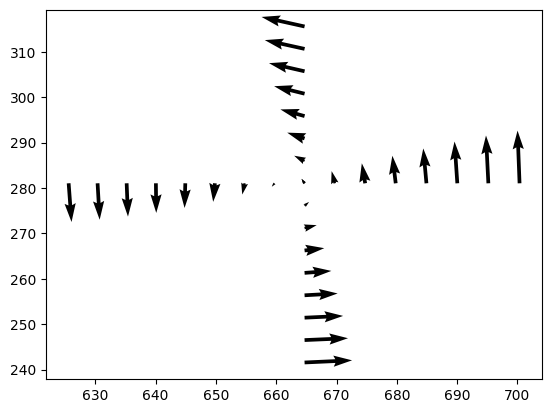

In [81]:
plt.quiver(x1, y1, u1, v1)
plt.quiver(x2, y2, u2, v2)


In [82]:
points1 = set(zip(x1, y1)); points2 = set(zip(x2, y2))
common_points = points1 & points2
# Remove duplicates from (x1, y1, u1, v1)
mask = ~np.array([(x, y) in common_points for x, y in zip(x1, y1)])
x1f = x1[mask]; y1f = y1[mask]; u1f = u1[mask]; v1f = v1[mask]
# Concatenate with unaltered second set
xi = np.concatenate([x1f, x2]); yi = np.concatenate([y1f, y2])
ui = np.concatenate([u1f, u2]); vi = np.concatenate([v1f, v2])

xc_dop, yc_dop, w_dop, AQ_dop, *_ = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
A_dop = np.sqrt(np.linalg.det(AQ_dop)) # det(Q) = 1, A = -psi0/Rc**2
q11_dop, q12_dop, q22_dop = AQ_dop[0,0]/A_dop, AQ_dop[1,0]/A_dop, AQ_dop[1,1]/A_dop
Q_dop = np.array([[q11_dop, q12_dop], [q12_dop, q22_dop]])

dx_dop, dy_dop = xi - xc_dop, yi - yc_dop
rho2_dop = q11_dop*dx_dop**2 + 2*q12_dop*dx_dop*dy_dop + q22_dop*dy_dop**2
# rho_dop = np.sqrt(rho2_dop)
rho_dop = np.sqrt((q11_dop*dx_dop + q12_dop*dy_dop)**2
                  + (q12_dop*dx_dop + q22_dop*dy_dop)**2) #||Qr||
vt_dop = np.abs(tangential_velocity(xi, yi, ui, vi, xc_dop, yc_dop, Q_dop))
idx_max_vt = np.where(vt_dop==np.max(vt_dop))[0][0]
rho_dop_max = rho_dop[idx_max_vt]
Rc_dop = rho_dop_max * np.sqrt(2) # Rc = rho_max * np.sqrt(2)
psi0_dop = - A_dop * Rc_dop**2 

df_res = pd.DataFrame({'xc': [xc_dop], 'yc': [yc_dop], 'q11': [q11_dop], 'q12': [q12_dop], 'q22': [q22_dop],
                            'Rc': [Rc_dop], 'psi0': [psi0_dop], 'A': [A_dop]})
df_res


,xc,yc,q11,q12,q22,Rc,psi0,A
0,662.310751,279.337611,1.029388,0.092864,0.979829,56.080067,-22.541674,0.007168


In [83]:
data = df_res.iloc[0]

dx, dy = X_local - data.xc, Y_local - data.yc
rho2 = (data.q11*dx + data.q12*dy)**2 + (data.q12*dx + data.q22*dy)**2 # ||Qr||
psi = data.psi0 * np.exp( - rho2 / data.Rc**2 )
u_dop =   data.psi0 * np.exp( - rho2 / data.Rc**2 ) * ( 2*data.q12*dx + 2*data.q22*dy ) / data.Rc**2
v_dop = - data.psi0 * np.exp( - rho2 / data.Rc**2 ) * ( 2*data.q11*dx + 2*data.q12*dy ) / Rc**2


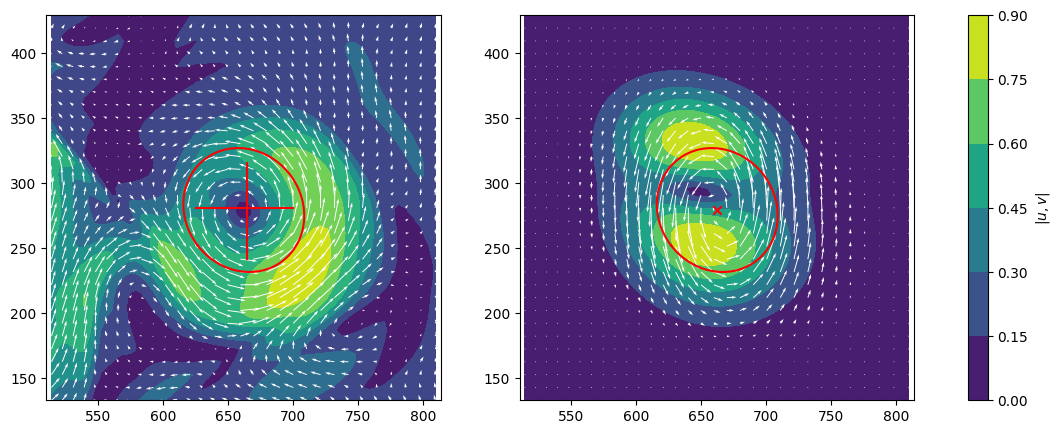

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))

c0 = axs[0].contourf(X_local, Y_local, np.hypot(u_local, v_local).T)
spac = 2
axs[0].quiver(X_local[::spac, ::spac], Y_local[::spac, ::spac],
              u_local[::spac, ::spac].T, v_local[::spac, ::spac].T, scale=10, color='w')
axs[0].plot(x1, y1, color='r'); axs[0].plot(x2, y2, color='r')
x_ell, y_ell = plot_ellipse(np.array([[data.q11, data.q12], [data.q12, data.q22]]),
                            center=(data.xc, data.yc), scale=data.Rc)
axs[0].plot(x_ell, y_ell, color='r')
axs[0].axis('equal')

c1 = axs[1].contourf(X_local, Y_local, np.hypot(u_dop, v_dop).T)
spac = 2
axs[1].quiver(X_local[::spac, ::spac], Y_local[::spac, ::spac],
              u_dop[::spac, ::spac], v_dop[::spac, ::spac], scale=10, color='w')
axs[1].scatter(data.xc, data.yc, marker='x', color='r')
axs[1].plot(x_ell, y_ell, color='r')
axs[1].axis('equal')

fig.colorbar(c1, ax=axs, orientation='vertical', label=r'$|u,v|$')
plt.show()


